# Understanding the Transformer Architecture: A Step-by-Step Guide

This notebook breaks down the key components of the Transformer architecture, the model that revolutionized Natural Language Processing (NLP) and powers modern Large Language Models (LLMs) like GPT. We will follow a structured path, starting from the limitations of older models and building up to the complete Transformer.

**Outline:**
* **a) Key limitations of RNNs and LSTMs**
* **b) Self-Attention and Multi-head Self-Attention**
* **c) Other building blocks of the Transformer**
* **d) The GPT Family and Decoder-only Transformers**

## a) Limitations of Older Models: RNNs and LSTMs

Before the Transformer, Recurrent Neural Networks (RNNs) and their more advanced variant, Long Short-Term Memory (LSTM) networks, were the state-of-the-art for sequence modeling tasks (e.g., machine translation, text generation). However, they had fundamental limitations.

An RNN processes a sequence word by word, maintaining a hidden state `h` that gets updated at each step.



This sequential nature, while intuitive, leads to several major problems:

1.  **Vanishing/Exploding Gradients:** During backpropagation, the gradient signal has to travel back through every single time step. For long sequences, this gradient can either shrink exponentially until it's useless (**vanishing gradient**) or grow exponentially until it destabilizes training (**exploding gradient**). This makes it very difficult for the model to learn long-range dependencies. LSTMs were designed with special "gates" to mitigate this, but the problem still persists for very long contexts.

2.  **Catastrophic Forgetting over Long Context:** The model's "memory" is compressed into a fixed-size hidden state vector. As it processes a long sequence, it's forced to overwrite its memory, often forgetting crucial information from the beginning of the context by the time it reaches the end. Imagine trying to remember the first sentence of a long paragraph by the time you read the last one—it's difficult!

3.  **Lack of Parallelizability:** The most significant computational bottleneck is the sequential processing. To calculate the hidden state for the 10th word, you *must* first calculate it for the 9th word, which requires the 8th, and so on. You cannot process all the words in the sequence at the same time. This makes training on massive datasets extremely slow.

## b) The Core Idea: Self-Attention

The "Attention Is All You Need" paper introduced the Transformer, which completely abandoned recurrence and instead relied entirely on a mechanism called **self-attention**.

Self-attention allows every word in a sentence to look at every *other* word in the same sentence to calculate a new, context-aware representation for itself. It weighs the importance of other words when encoding a specific word.

### The Math Behind It: Queries, Keys, and Values

The mechanism works by projecting the input embedding of each word into three new vectors: a **Query (Q)**, a **Key (K)**, and a **Value (V)**.

* **Query (Q):** Represents the current word's "question" or what it's looking for.
* **Key (K):** Represents another word's "label" or what kind of information it offers.
* **Value (V):** Represents the actual content or substance of that other word.

The core operation is the **Scaled Dot-Product Attention**:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

Let's break this down:
1.  **$QK^T$**: We compute the dot product of the Query vector of one word with the Key vectors of all other words. This gives a **similarity score**. A higher score means the key (and thus the word it represents) is more relevant to the query.
2.  **$\frac{1}{\sqrt{d_k}}$**: We scale the scores by the square root of the dimension of the key vectors ($d_k$). This is a crucial stabilization step. Without it, for large values of $d_k$, the dot products could become very large, pushing the softmax function into regions with extremely small gradients, making learning difficult.
3.  **$\text{softmax}$**: The scaled scores are passed through a softmax function, which converts them into probabilities (attention weights) that all sum to 1. These weights determine how much focus to place on each word in the sequence.
4.  **$V$**: Finally, we multiply these attention weights by the Value vectors of each word and sum them up. This produces a new vector for the current word, which is a weighted sum of all other words' values, enriched with information from its most relevant companions.

### Progression to Multi-Head Attention

A single attention mechanism might focus on only one type of relationship (e.g., subject-verb). To capture diverse relationships (syntactic, semantic, etc.), the Transformer uses **Multi-Head Attention**.

Instead of one set of Q, K, V projections, we have multiple "heads." Each head has its own set of learned projection matrices.



This means we run the self-attention process multiple times in parallel, each in its own "representation subspace." Each head can learn to focus on different aspects of the language. The outputs from all the heads are then concatenated and passed through a final linear layer to produce the final output of the Multi-Head Attention block. This allows the model to jointly attend to information from different perspectives.

In [2]:
pip install numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 9.3 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

def scaled_dot_product_attention(Q, K, V):
    """
    Simple implementation of Scaled Dot-Product Attention.
    
    Args:
        Q (np.array): Query matrix. Shape: (..., seq_len_q, depth)
        K (np.array): Key matrix. Shape: (..., seq_len_k, depth)
        V (np.array): Value matrix. Shape: (..., seq_len_v, depth_v)
        Note: seq_len_k and seq_len_v must be the same.
        
    Returns:
        tuple: (output, attention_weights)
    """
    # Get the dot product of Q and K, transpose K
    matmul_qk = np.matmul(Q, K.swapaxes(-2, -1))
    
    # Get the dimension of the key vector
    d_k = K.shape[-1]
    
    # Scale the dot product
    scaled_attention_logits = matmul_qk / np.sqrt(d_k)
    
    # Apply softmax to get the attention weights
    attention_weights = softmax(scaled_attention_logits)
    
    # Multiply the weights by the Value matrix
    output = np.matmul(attention_weights, V)
    
    return output, attention_weights

# --- Example ---
# Let's imagine a sequence of 3 words (seq_len=3)
# with an embedding dimension of 4 (depth=4)
np.random.seed(42)
seq_len = 3
depth = 4

# Let's assume these are our Query, Key, and Value matrices
# In a real model, these would be learned projections of the input embeddings
Q = np.random.rand(seq_len, depth)
K = np.random.rand(seq_len, depth)
V = np.random.rand(seq_len, depth)

print("--- Inputs ---")
print(f"Q (Query):\n{Q}\n")
print(f"K (Key):\n{K}\n")
print(f"V (Value):\n{V}\n")

output, attention_weights = scaled_dot_product_attention(Q, K, V)

print("--- Outputs ---")
print(f"Attention Weights (after softmax):\n{attention_weights}\n")
print("Each row shows how much a word (row index) attends to all other words (column index).")
print(f"\nFinal Contextualized Output:\n{output}\n")

--- Inputs ---
Q (Query):
[[0.37454012 0.95071431 0.73199394 0.59865848]
 [0.15601864 0.15599452 0.05808361 0.86617615]
 [0.60111501 0.70807258 0.02058449 0.96990985]]

K (Key):
[[0.83244264 0.21233911 0.18182497 0.18340451]
 [0.30424224 0.52475643 0.43194502 0.29122914]
 [0.61185289 0.13949386 0.29214465 0.36636184]]

V (Value):
[[0.45606998 0.78517596 0.19967378 0.51423444]
 [0.59241457 0.04645041 0.60754485 0.17052412]
 [0.06505159 0.94888554 0.96563203 0.80839735]]

--- Outputs ---
Attention Weights (after softmax):
[[0.31164829 0.37066075 0.31769096]
 [0.32266579 0.33486977 0.34246444]
 [0.33283257 0.33507568 0.33209175]]

Each row shows how much a word (row index) attends to all other words (column index).

Final Contextualized Output:
[[0.38238456 0.56336845 0.59419359 0.48028741]
 [0.36781777 0.59386381 0.59857094 0.49987658]
 [0.37190176 0.5920136  0.59070988 0.49675455]]



## c) Other Building Blocks of the Transformer

Self-attention is the star, but several other components are essential to make the Transformer work.

### 1. Tokenization and Input Embeddings
Text is first broken down into smaller pieces called **tokens**. This can be done at the word level, character level, or sub-word level (e.g., `transformer` -> `transform`, `er`). Sub-word tokenization (like BPE or WordPiece) is most common as it handles rare words and maintains meaning.

Each token is then mapped to a numerical vector using a learned **Embedding** matrix.

### 2. Positional Encoding
Since the self-attention mechanism itself has no sense of word order (it treats the input as a "bag of words"), we must explicitly inject information about the position of each word in the sequence. This is done by adding a **Positional Encoding** vector to the input embedding.

The original paper used sine and cosine functions of different frequencies:

$$
PE_{(pos, 2i)} = \sin(pos / 10000^{2i/d_{\text{model}}})
$$
$$
PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i/d_{\text{model}}})
$$

Where `pos` is the word's position, `i` is the dimension within the embedding vector, and `d_model` is the total embedding dimension. This approach is clever because it allows the model to easily learn relative positions, as the encoding for any position can be represented as a linear function of other positions.

In [4]:
pip install matplotlib

  Using cached fonttools-4.59.0-cp313-cp313-macosx_10_13_universal2.whl.metadata (107 kB)
  Using cached pillow-11.3.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (9.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 11.5 MB/s eta 0:00:00a 0:00:01
Using cached fonttools-4.59.0-cp313-cp313-macosx_10_13_universal2.whl (2.8 MB)
Using cached pillow-11.3.0-cp313-cp313-macosx_11_0_arm64.whl (4.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


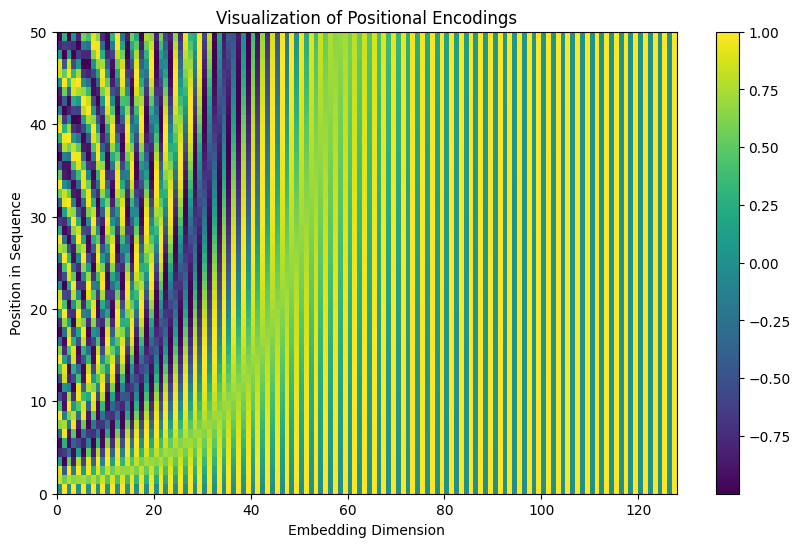

In [5]:
import matplotlib.pyplot as plt

def get_positional_encoding(max_seq_len, d_model):
    """Generates positional encoding matrix."""
    pos = np.arange(max_seq_len)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    
    # Calculate the angle rates for sine and cosine
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    angle_rads = pos * angle_rates
    
    # Apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    
    # Apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    return angle_rads

# --- Example Visualization ---
d_model = 128  # Embedding dimension
max_seq_len = 50 # Max sequence length

pos_encoding = get_positional_encoding(max_seq_len, d_model)

plt.figure(figsize=(10, 6))
plt.pcolormesh(pos_encoding, cmap='viridis')
plt.xlabel('Embedding Dimension')
plt.ylabel('Position in Sequence')
plt.title('Visualization of Positional Encodings')
plt.colorbar()
plt.show()

### 3. Add & Norm (Residual Connections & Layer Normalization)

Each sub-layer in the Transformer (like Multi-Head Attention or the Feed-Forward Network) has a residual connection around it, followed by layer normalization.

The output of each sub-layer is `LayerNorm(x + Sublayer(x))`.

* **Residual (or "Skip") Connection:** The `x + Sublayer(x)` part. This allows the gradient to flow directly through the network, bypassing transformations. It is a critical technique to train very deep networks, as it helps prevent the vanishing gradient problem.
* **Layer Normalization:** This normalizes the output of the sub-layer, stabilizing the training process by keeping the distribution of activations consistent.

### 4. The Encoder-Decoder Architecture
The original Transformer was designed for machine translation and had two main parts: an **Encoder** and a **Decoder**.

* **Encoder:** Its job is to read the input sentence (e.g., in German) and build a rich contextual representation of it. It consists of a stack of identical layers. Each layer contains two sub-layers: a Multi-Head Self-Attention block and a simple, position-wise Feed-Forward Network.

* **Decoder:** Its job is to generate the output sentence (e.g., in English) one token at a time. It also consists of a stack of identical layers. The decoder layers have **three** sub-layers:
    1.  A **Masked** Multi-Head Self-Attention block. The "masking" prevents the decoder from "cheating" by looking at future tokens in the output sequence it is trying to generate.
    2.  An **Encoder-Decoder Cross-Attention** block.
    3.  A position-wise Feed-Forward Network.

### 5. Encoder-Decoder Cross Attention
This is the key step where the two halves of the model communicate. In this block, the **Keys (K)** and **Values (V)** come from the final output of the **Encoder**. The **Queries (Q)** come from the previous decoder layer.

This allows the decoder, at each step of generating a new word, to "look back" and pay attention to the most relevant parts of the original *input* sentence. For example, when translating a pronoun, the cross-attention mechanism can help it focus on the noun it refers to in the source sentence.

## d) The GPT Family, Decoder-only, and Encoder-only Transformers

While the original Encoder-Decoder architecture is powerful for sequence-to-sequence tasks like translation, research quickly found that using just one half of the model was highly effective for other tasks.

### Decoder-only Transformers (e.g., GPT family)

This is the main direction of research for modern LLMs.

* **Architecture:** These models are essentially just the **Decoder** stack from the original Transformer. They use **masked self-attention**, meaning when predicting the next token, they can only attend to the tokens that came before it.
* **How they work:** You give them a starting sequence of text (a "prompt"), and they predict the most probable next token. That new token is then added to the sequence, and the process repeats. This auto-regressive process is why they are often called "generative" models.
* **Applications:** Perfect for open-ended text generation, chatbots, summarization, writing code, and more. The entire GPT (Generative Pre-trained Transformer) family, including GPT-2, GPT-3, and their successors, are decoder-only models.

### Encoder-only Transformers (e.g., BERT, RoBERTa)

* **Architecture:** These models are just the **Encoder** stack from the original Transformer.
* **How they work:** Unlike a decoder, an encoder can look at the *entire* input sequence at once (bidirectional attention). They are not designed to generate text token-by-token. Instead, they are pre-trained to understand context by, for example, filling in missing ("masked") words in a sentence (Masked Language Modeling or MLM).
* **Applications:** They excel at creating high-quality **Embedding Models**. Because they see the whole sentence, they produce rich, context-aware vector representations (embeddings) for words or entire sentences. These embeddings are then used as features for downstream tasks like:
    * Text Classification (e.g., sentiment analysis)
    * Named Entity Recognition (NER)
    * Question Answering
    * Sentence-pair similarity